<h1> Instructions </h1>

<h3> For this question, we found it tidier and more efficient to create a separate script containing our model fitting pipeline and plotiing/ evaluation functions and then use this notebook to call in each function </h3>


In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns

# Import our pipeline module
import Q3_pipeline_script as ml

In [2]:
data = pd.read_csv('Final_SBA_Dataset_v3.csv', index_col= "LoanNr_ChkDgt")


In [3]:
data.describe()
data.head()

,Term,NoEmp,GrAppv,Default,Is_New,Is_Franchise,Is_LowDoc,Is_RevLineCr,Is_Solo,CreatedJobs_Any,RetainedJobs_Any,SBA_Guarantee_Ratio,HighRisk_State,HighRisk_Industry
LoanNr_ChkDgt,,,,,,,,,,,,,,
1000014003,84,4,60000,0,1,0,1,0,0,0,0,0.80,0,1
1000024006,60,2,40000,0,1,0,1,0,0,0,0,0.80,0,1
1000034009,180,7,287000,0,0,0,0,0,0,0,0,0.75,0,0
1000044001,60,2,35000,0,0,0,1,0,0,0,0,0.80,0,0
1000084002,120,19,517000,0,0,0,0,0,0,0,0,0.75,0,0


<h1> Data Pre-Processing </h1>

<h3> This process splits our data into 70/30 test train splits, applies scaling to the X_Train and X_Test and has optional data balancing via SMOTE which is the default setting</h3>
<h3> Given the majority of the negative class in the dataset and the commercially sensitive nature of not accurately capturing the minority positive class, we decided to balance our training set </h3> 
<h3> This allows them to better capture patterns of the minority class in order to improve generalisation and prevent bias to the majority class </h3>

In [4]:
X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, feature_names = ml.preprocess_data(data)  # this includes smote sampling - the traun and test sets returned are all balanced

 Applied SMOTE: Resampled class distribution: {0: 380751, 1: 380751}


In [ ]:
#Setting up our non SMOTE balanced data sets to pass into our cross validation function later on. We cannot cross validate on pre-SMOTED data as this will inflate CV perfromance metrics
# Thus we will pass in imbalanced data to our CV function with the training set balanced by SMOTE on each fold with the validation set witheld as imbalanced for accurate evaluation of the model performance across folds.

df = data.copy()
df = df.map(lambda x: int(x) if isinstance(x, bool) else x)
X = df.drop(columns=["Default"])
y = df["Default"]
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_imb = scaler.fit_transform(X_train_imb)
X_test_imb = scaler.transform(X_test_imb)

y_train_imb = y_train_imb.reset_index(drop=True)
print(y_train_imb)

0         0
1         0
2         0
3         1
4         1
         ..
490799    0
490800    0
490801    0
490802    0
490803    0
Name: Default, Length: 490804, dtype: int64


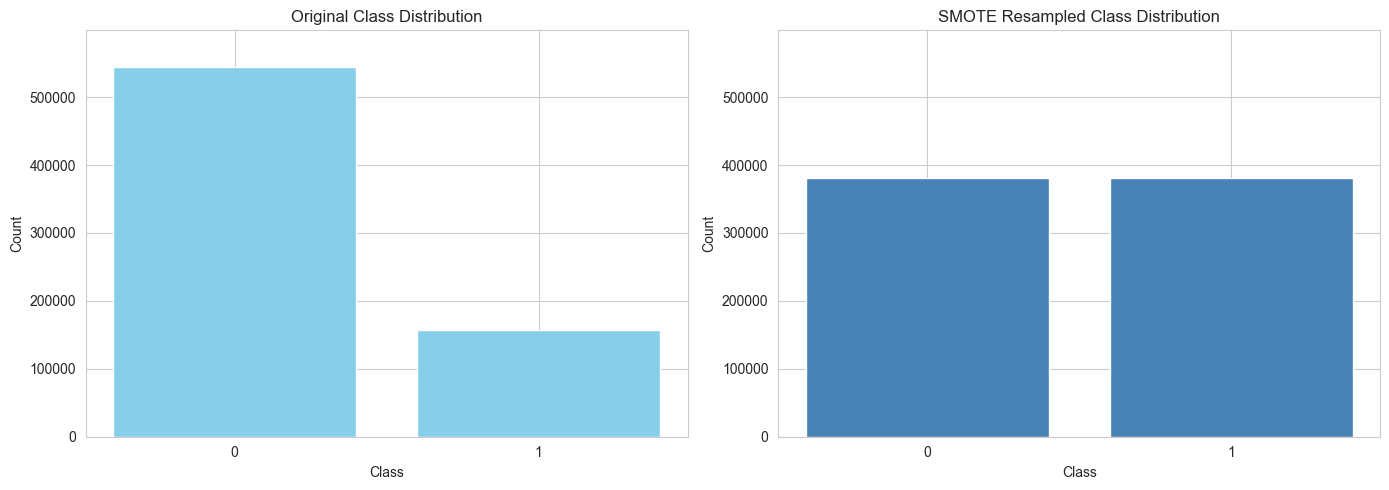

In [ ]:
y = data["Default"]

sns.set_style("whitegrid")

# Prepare value counts
original_counts = y.value_counts()
resampled_counts = y_train.value_counts()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot original distribution
axes[0].bar(original_counts.index.astype(str), original_counts.values, color='skyblue')
axes[0].set_title('Original Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max(original_counts.max(), resampled_counts.max()) * 1.1)

# Plot resampled distribution
axes[1].bar(resampled_counts.index.astype(str), resampled_counts.values, color='steelblue')
axes[1].set_title('SMOTE Resampled Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, max(original_counts.max(), resampled_counts.max()) * 1.1)

plt.tight_layout()
plt.show()

<h1> Random Forest </h1> 

<h3> We chose to use RandomSearch tuning instead of GridSearch due to its reduced computational complexity </h3>

In [7]:
# Setting variable names to pass into functions
model_name= "Random Forest"
model_type = 'rf' 

In [8]:
bal_model = ml.train_model(model_type, X_train_scaled, y_train, tune=True, n_iter = 10)  # tune=True enables RandomizedSearchCV for RF

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuning model search complete ...

 Best Model Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


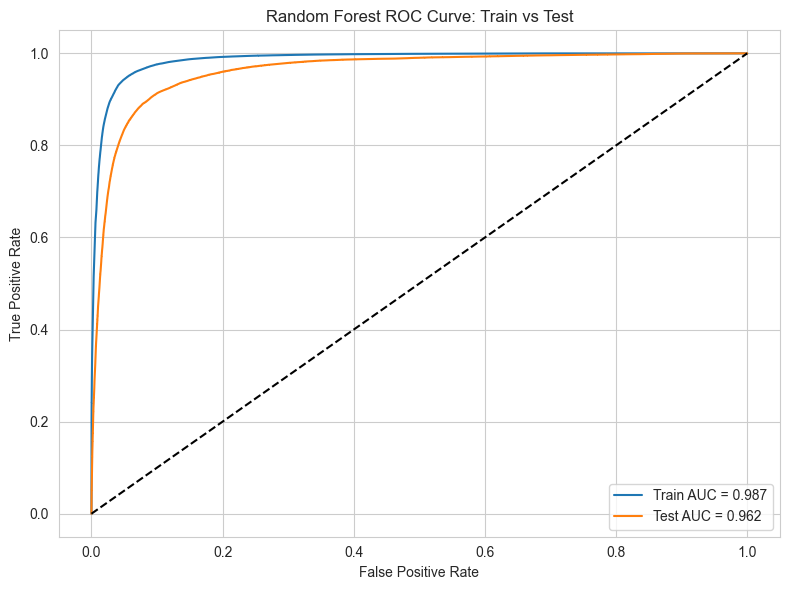

In [9]:
ml.plot_roc_train_vs_test(model_name, bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9640  0.2135     0.5662      0.1737   0.8707    0.7134  0.0360
1       0.20  0.9380  0.1411     0.6578      0.1233   0.8976    0.7733  0.0620
2       0.35  0.9065  0.0931     0.7378      0.0932   0.9067    0.8135  0.0935
3       0.50  0.8734  0.0673     0.7896      0.0806   0.9026    0.8294  0.1266


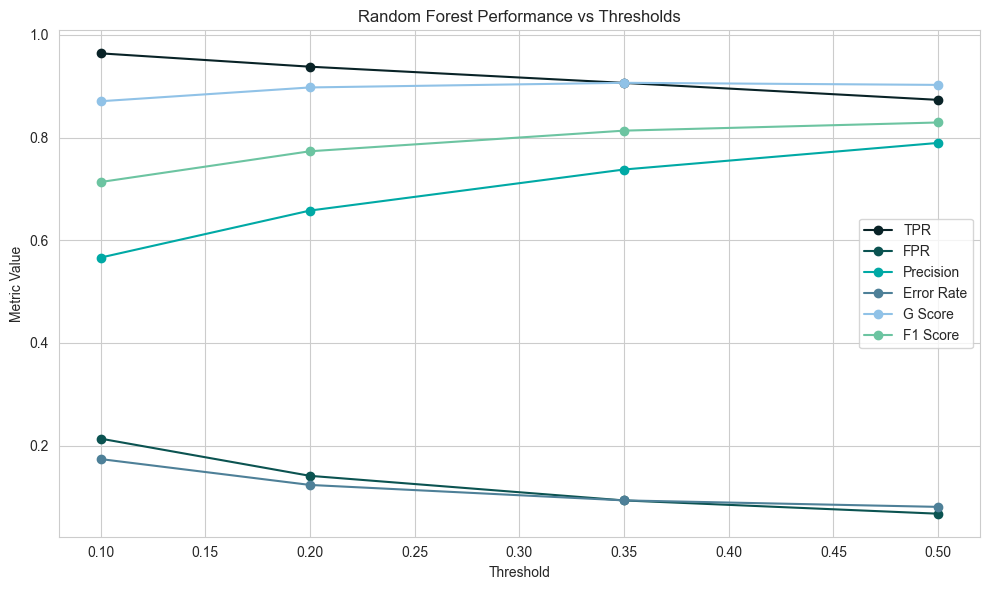

In [10]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(model_name, df =threshold_df)

In [11]:
ml.cross_validate_thresholds(model = bal_model,X = X_train_imb,y= y_train_imb)

 Applied SMOTE: Resampled class distribution: {0: 304600, 1: 304600}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}

Cross-Validated Metrics across Thresholds:
   Threshold  F1_mean  Recall_mean  Precision_mean  FNR_mean  FPR_mean  \
0       0.10   0.7113       0.9609          0.5646    0.0391    0.2142   
1       0.20   0.7725       0.9358          0.6578    0.0642    0.1407   
2       0.35   0.8137       0.9034          0.7403    0.0966    0.0916   
3       0.50   0.8294       0.8709          0.7917    0.1291    0.0662   

   Error_mean  
0      0.1749  
1      0.1236  
2      0.0928  
3      0.0803  


,Threshold,F1_mean,Recall_mean,Precision_mean,FNR_mean,FPR_mean,Error_mean
0,0.10,0.7113,0.9609,0.5646,0.0391,0.2142,0.1749
1,0.20,0.7725,0.9358,0.6578,0.0642,0.1407,0.1236
2,0.35,0.8137,0.9034,0.7403,0.0966,0.0916,0.0928
3,0.50,0.8294,0.8709,0.7917,0.1291,0.0662,0.0803


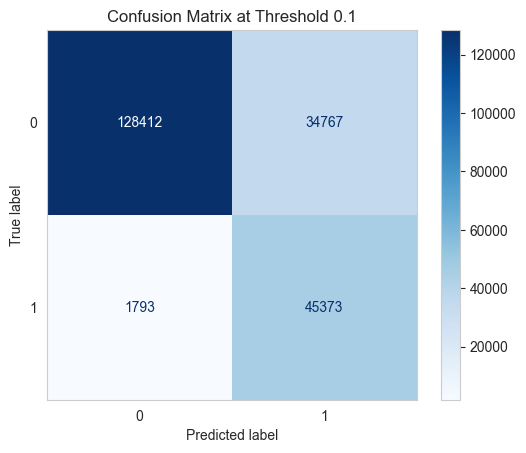

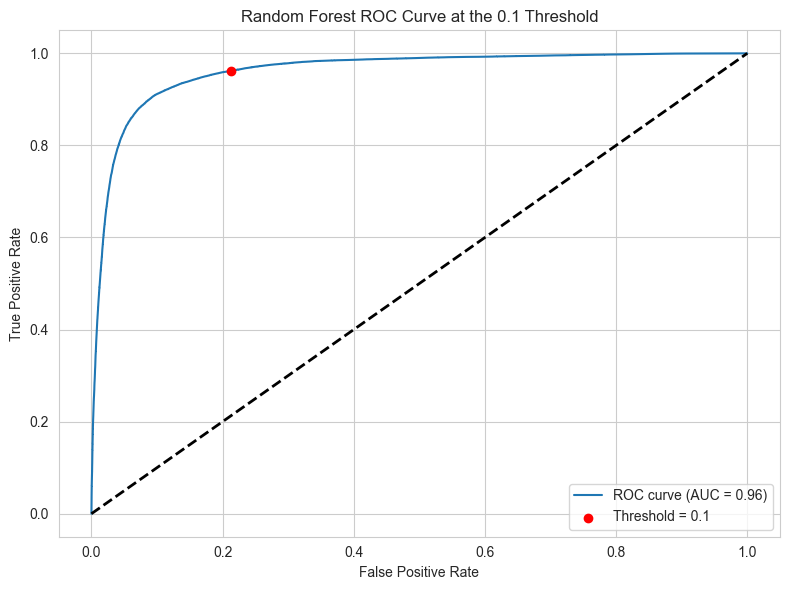

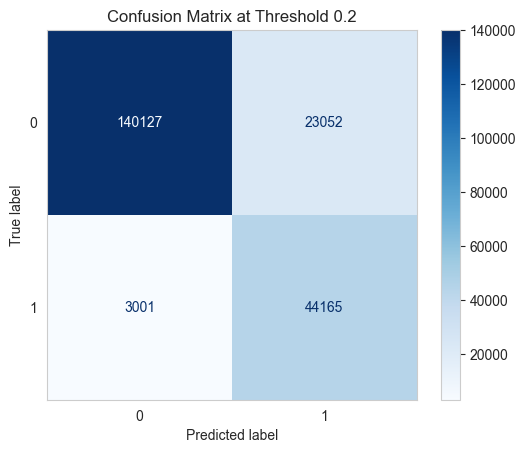

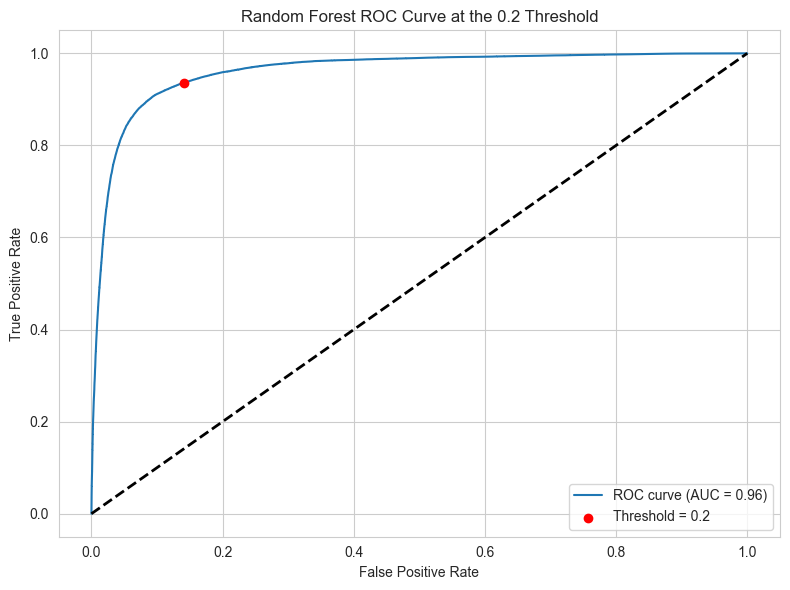

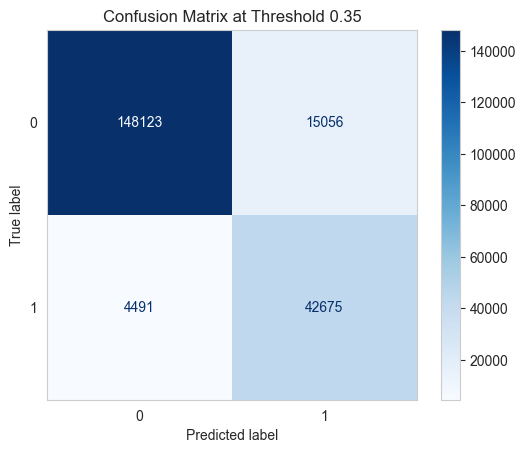

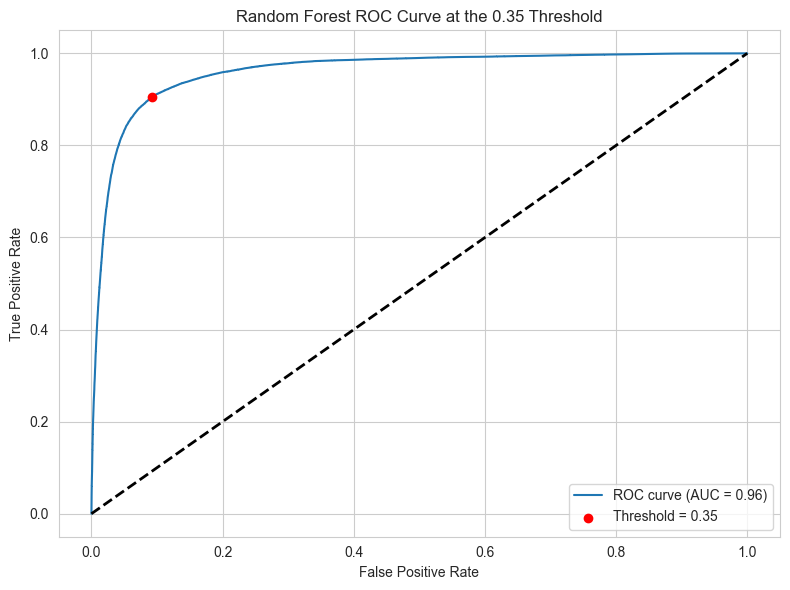

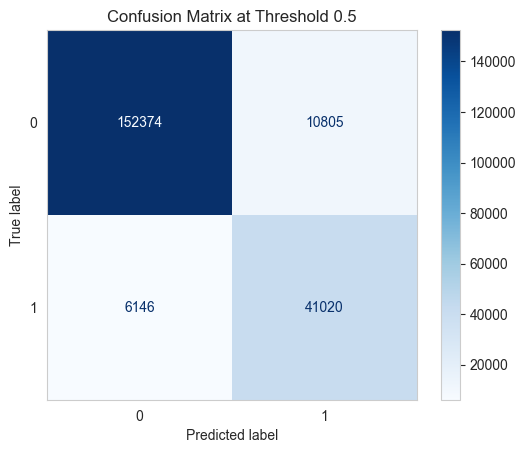

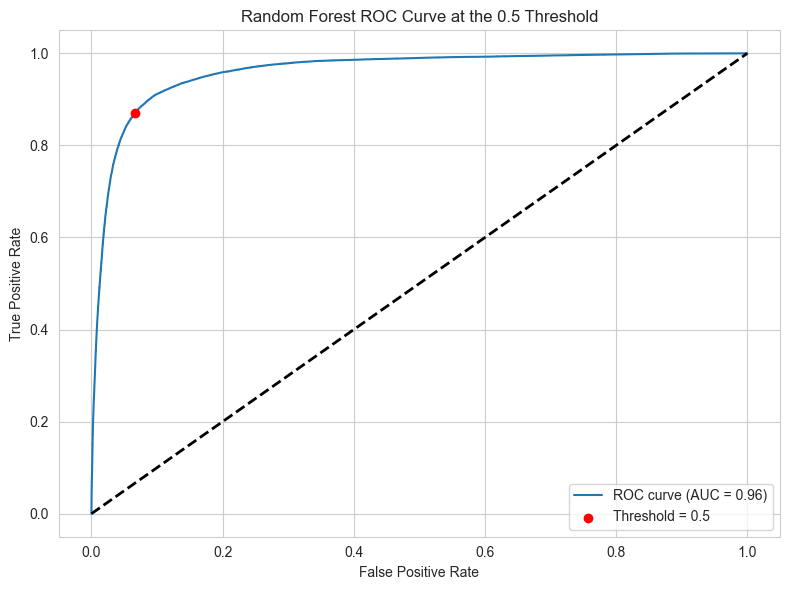

In [12]:
thresholds=[0.1, 0.2, 0.35, 0.5]
for threshold in thresholds:
    ml.plot_confusion_matrix_at_threshold(bal_model, X_test_scaled, y_test, threshold=threshold)
    ml.plot_roc_with_threshold(model_name,bal_model, X_test_scaled, y_test, threshold=threshold)

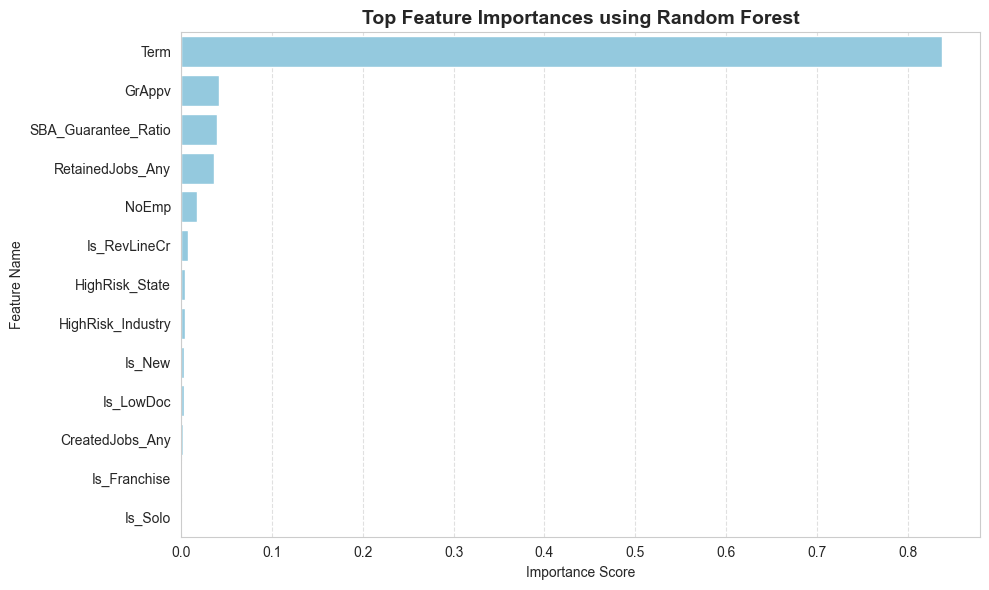

In [13]:
ml.plot_feature_importance(model_name,bal_model, feature_names)

<h1> Boosting - XGBoost </h1>

In [14]:
model_name= "XGBoost"
model_type = 'xgb' 

In [15]:
bal_model = ml.train_model(model_type, X_train_scaled, y_train, tune=True, n_iter= 10)  # tune=True enables tuning with option to choose RandomSearch or GridSearch

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuning model search complete ...

 Best Model Parameters: {'subsample': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


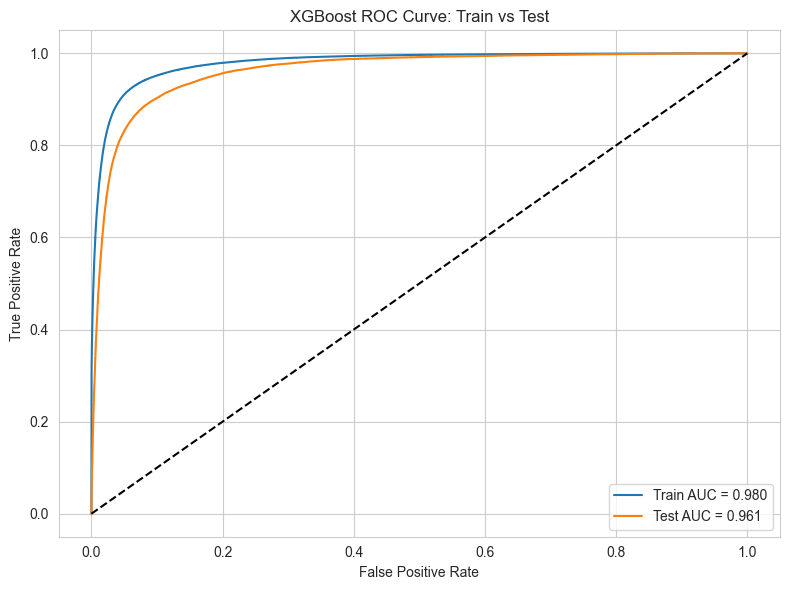

In [16]:
ml.plot_roc_train_vs_test(model_name,bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9722  0.2634     0.5162      0.2106   0.8462    0.6743  0.0278
1       0.20  0.9452  0.1718     0.6139      0.1456   0.8848    0.7444  0.0548
2       0.35  0.9047  0.1020     0.7194      0.1005   0.9014    0.8015  0.0953
3       0.50  0.8644  0.0656     0.7920      0.0813   0.8987    0.8266  0.1356


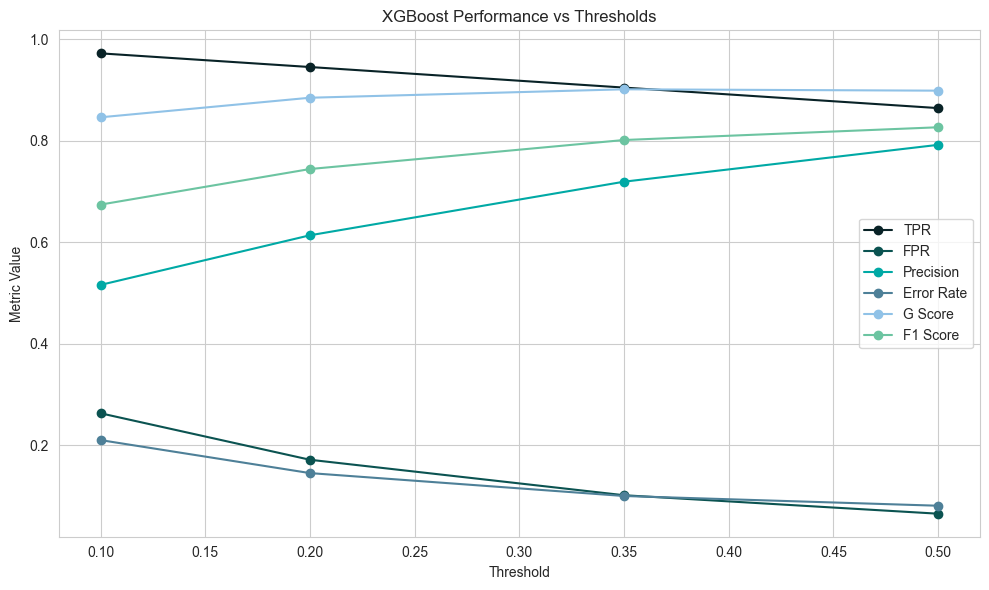

In [17]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(model_name,threshold_df)

In [18]:
ml.cross_validate_thresholds(bal_model, X_train_imb, y_train_imb)

 Applied SMOTE: Resampled class distribution: {0: 304600, 1: 304600}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}

Cross-Validated Metrics across Thresholds:
   Threshold  F1_mean  Recall_mean  Precision_mean  FNR_mean  FPR_mean  \
0       0.10   0.6807       0.9703          0.5243    0.0297    0.2546   
1       0.20   0.7499       0.9449          0.6217    0.0551    0.1662   
2       0.35   0.8043       0.9043          0.7242    0.0957    0.0996   
3       0.50   0.8272       0.8637          0.7937    0.1363    0.0649   

   Error_mean  
0      0.2041  
1      0.1413  
2      0.0987  
3      0.0809  


,Threshold,F1_mean,Recall_mean,Precision_mean,FNR_mean,FPR_mean,Error_mean
0,0.10,0.6807,0.9703,0.5243,0.0297,0.2546,0.2041
1,0.20,0.7499,0.9449,0.6217,0.0551,0.1662,0.1413
2,0.35,0.8043,0.9043,0.7242,0.0957,0.0996,0.0987
3,0.50,0.8272,0.8637,0.7937,0.1363,0.0649,0.0809


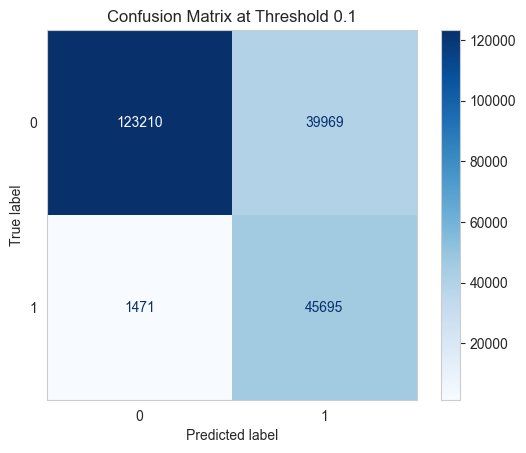

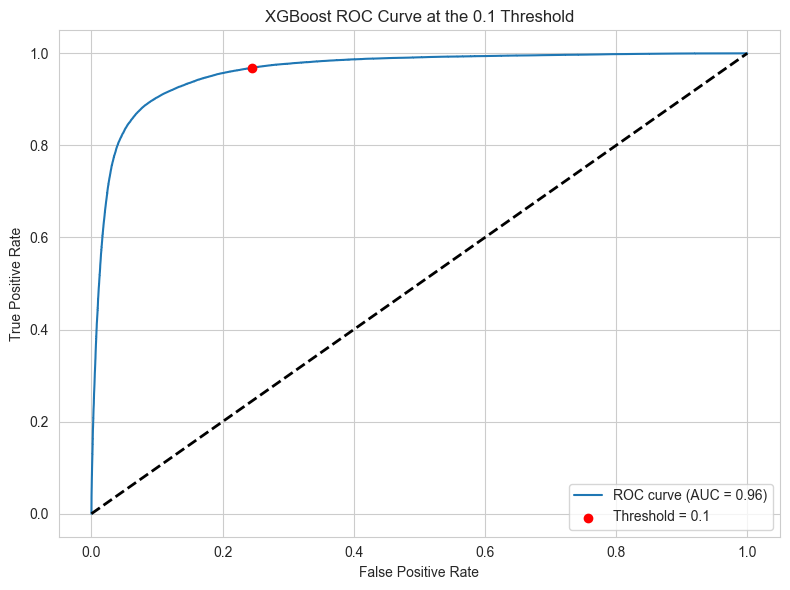

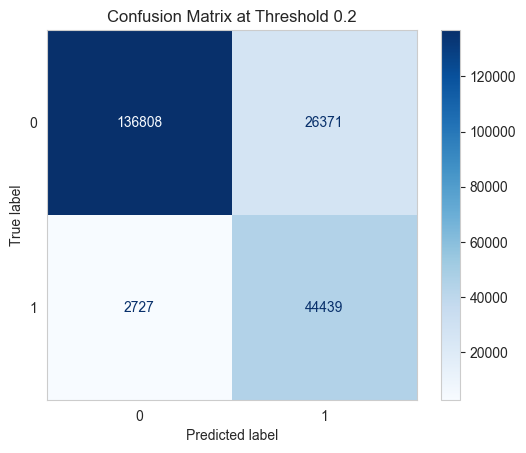

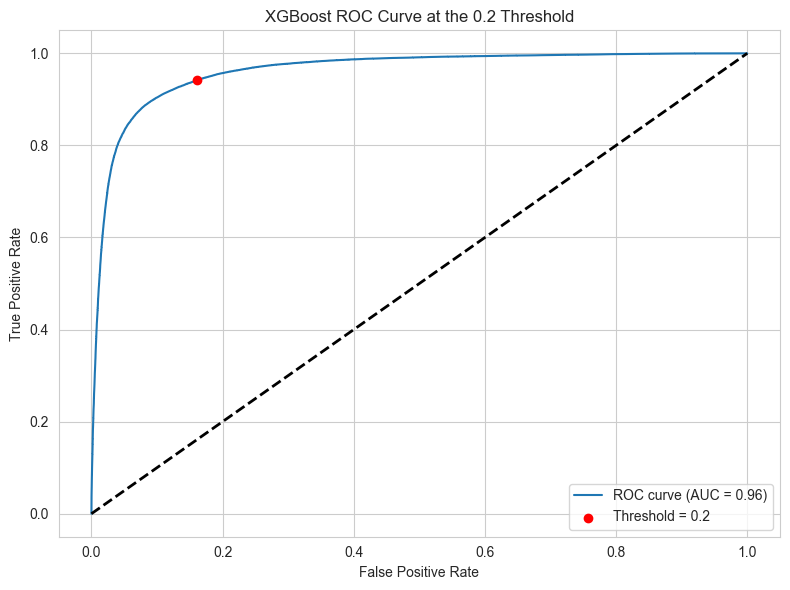

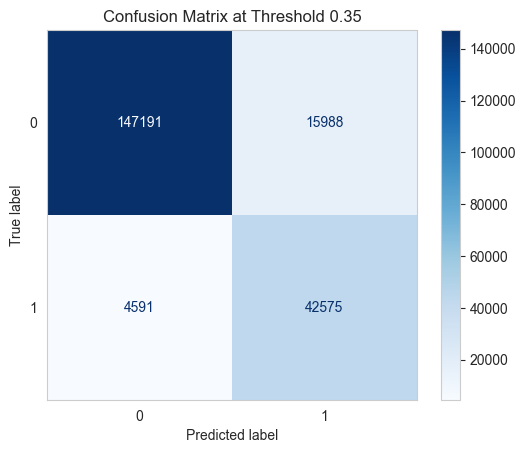

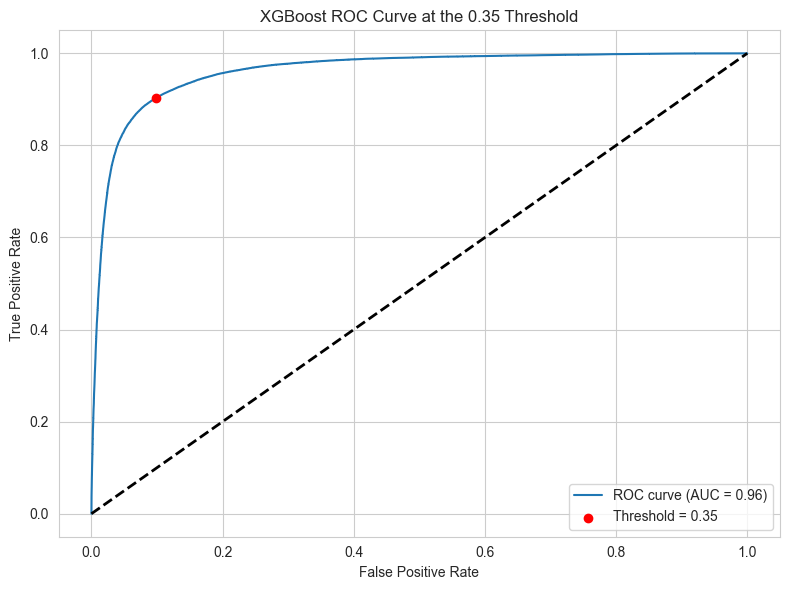

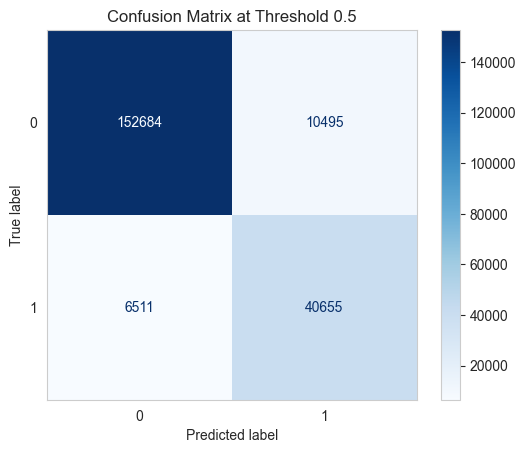

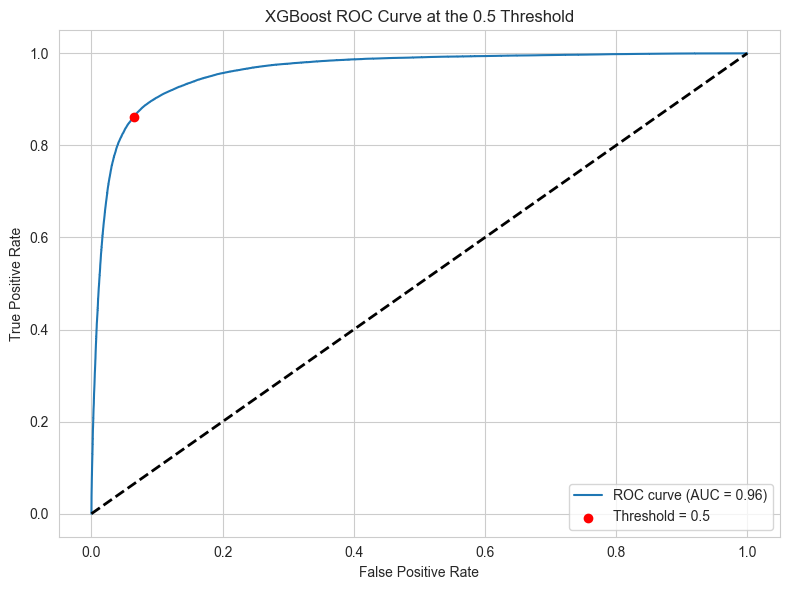

In [19]:
thresholds=[0.1, 0.2, 0.35, 0.5]
for threshold in thresholds:
    ml.plot_confusion_matrix_at_threshold(bal_model, X_test_scaled, y_test, threshold=threshold)
    ml.plot_roc_with_threshold(model_name, bal_model, X_test_scaled, y_test, threshold=threshold)

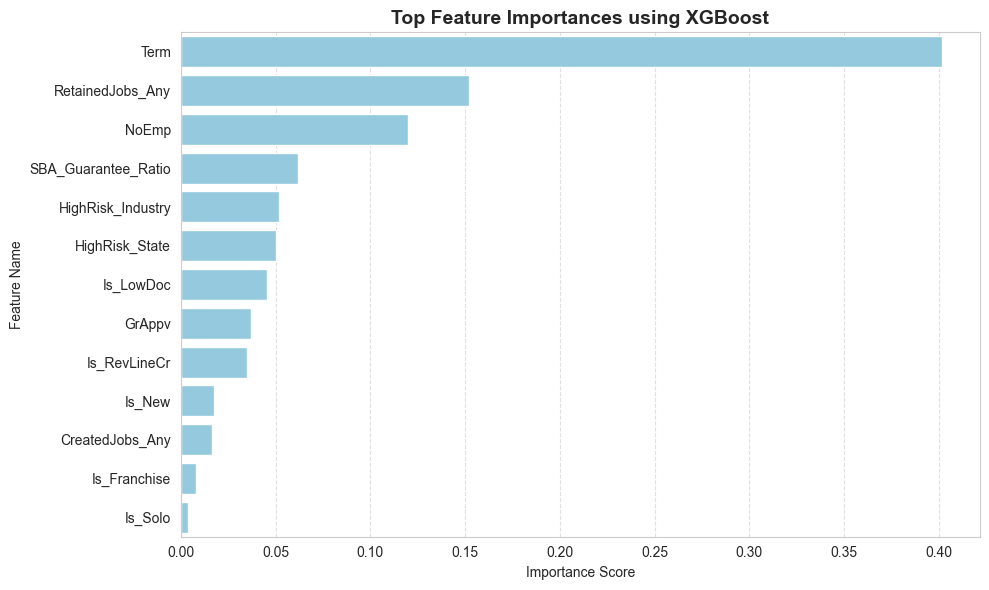

In [20]:
ml.plot_feature_importance(model_name,bal_model, feature_names)

<h1> KNN </h1>

<h3> ROC chosen as target scoring metric here to maximise abilty of model to distinguish between classes, setting F1 score as with our other models results in the KNN to "Cheat" and return an optimal k= 1 which results in overfitiing  </h3>

In [21]:
model_name= "K-Nearest Neighbour"
model_type = 'knn' 

In [22]:
model_type = 'knn'
bal_model = ml.train_model(model_type, X_train_scaled, y_train, tune=True, n_iter = 8, scoring= "roc_auc")  

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuning model search complete ...

 Best Model Parameters: {'n_neighbors': 7}


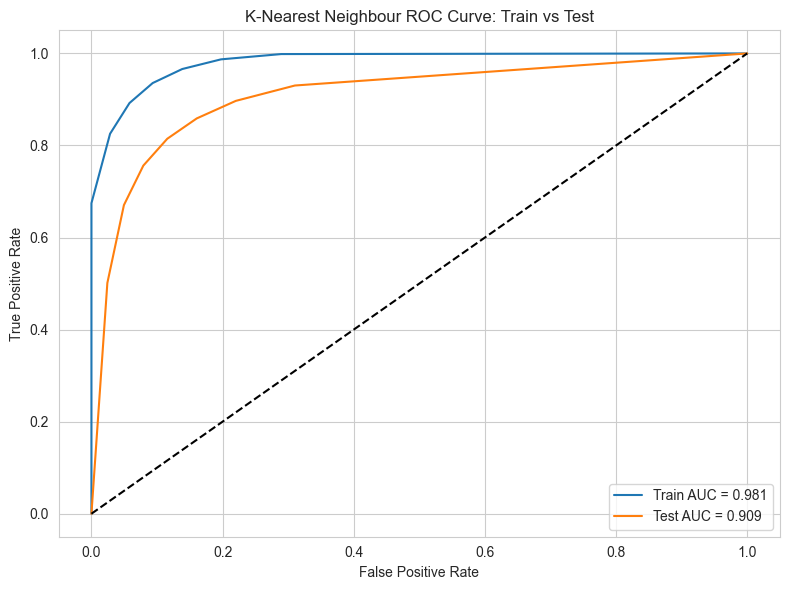

In [23]:
ml.plot_roc_train_vs_test(model_name,bal_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [24]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test=X_test_scaled, y_test= y_test, thresholds=[0.5])


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0        0.5  0.8146  0.1156     0.6706      0.1313   0.8488    0.7357  0.1854


In [ ]:
ml.knn_error_plot(X_train_scaled, X_test_scaled, y_train, y_test, k_values=[1,3,5,7,9,11])

Metrics and Charting for k = 1



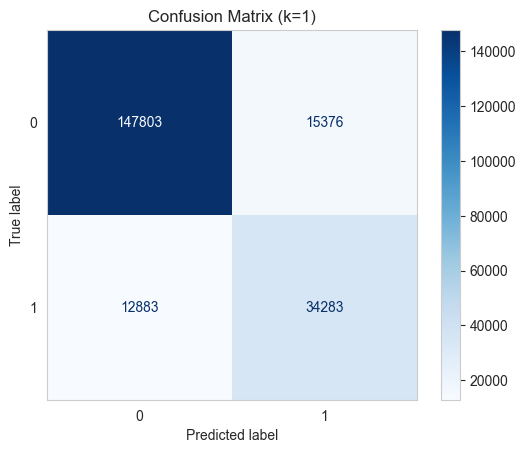

               Term  NoEmp  GrAppv  Default  Is_New  Is_Franchise  Is_LowDoc  \
LoanNr_ChkDgt                                                                  
1000014003       84      4   60000        0       1             0          1   
1000024006       60      2   40000        0       1             0          1   
1000034009      180      7  287000        0       0             0          0   
1000044001       60      2   35000        0       0             0          1   
1000084002      120     19  517000        0       0             0          0   
...             ...    ...     ...      ...     ...           ...        ...   
9995573004       60      6   70000        0       0             0          0   
9995603000       60      6   85000        0       0             0          0   
9995613003      108     26  300000        0       0             0          0   
9995973006       60      6   75000        1       0             0          1   
9996003010       48      1   30000      

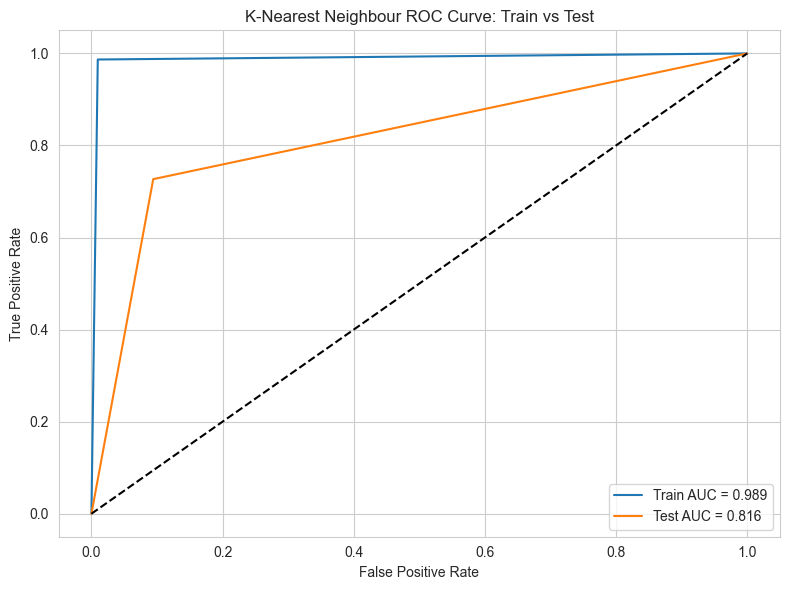

Metrics and Charting for k = 3



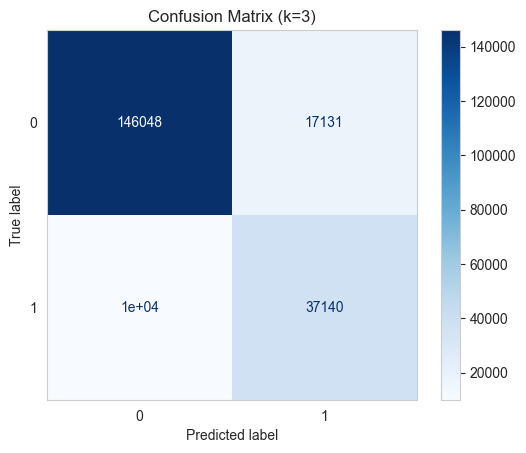

               Term  NoEmp  GrAppv  Default  Is_New  Is_Franchise  Is_LowDoc  \
LoanNr_ChkDgt                                                                  
1000014003       84      4   60000        0       1             0          1   
1000024006       60      2   40000        0       1             0          1   
1000034009      180      7  287000        0       0             0          0   
1000044001       60      2   35000        0       0             0          1   
1000084002      120     19  517000        0       0             0          0   
...             ...    ...     ...      ...     ...           ...        ...   
9995573004       60      6   70000        0       0             0          0   
9995603000       60      6   85000        0       0             0          0   
9995613003      108     26  300000        0       0             0          0   
9995973006       60      6   75000        1       0             0          1   
9996003010       48      1   30000      

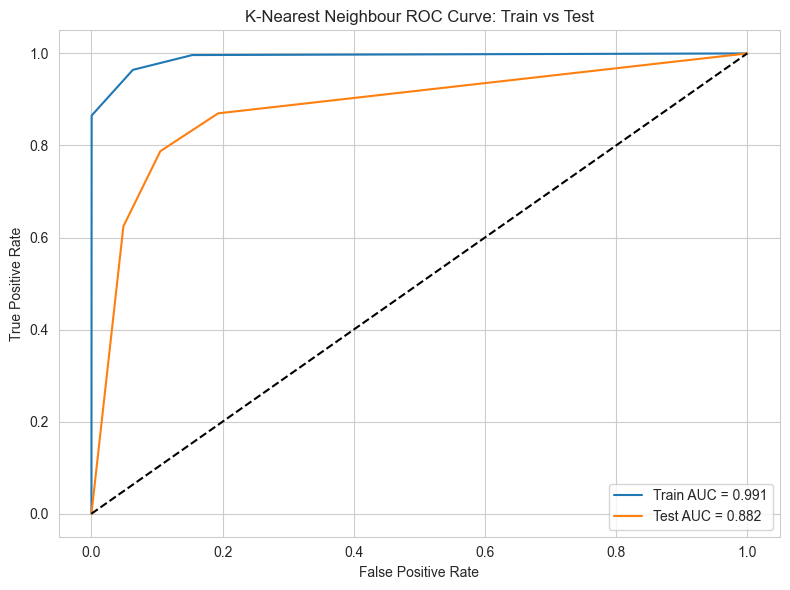

Metrics and Charting for k = 5



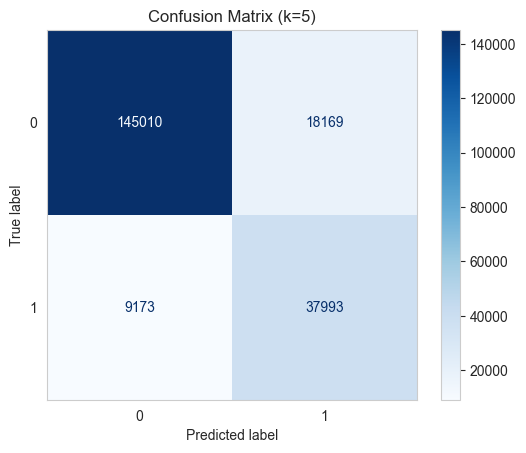

               Term  NoEmp  GrAppv  Default  Is_New  Is_Franchise  Is_LowDoc  \
LoanNr_ChkDgt                                                                  
1000014003       84      4   60000        0       1             0          1   
1000024006       60      2   40000        0       1             0          1   
1000034009      180      7  287000        0       0             0          0   
1000044001       60      2   35000        0       0             0          1   
1000084002      120     19  517000        0       0             0          0   
...             ...    ...     ...      ...     ...           ...        ...   
9995573004       60      6   70000        0       0             0          0   
9995603000       60      6   85000        0       0             0          0   
9995613003      108     26  300000        0       0             0          0   
9995973006       60      6   75000        1       0             0          1   
9996003010       48      1   30000      

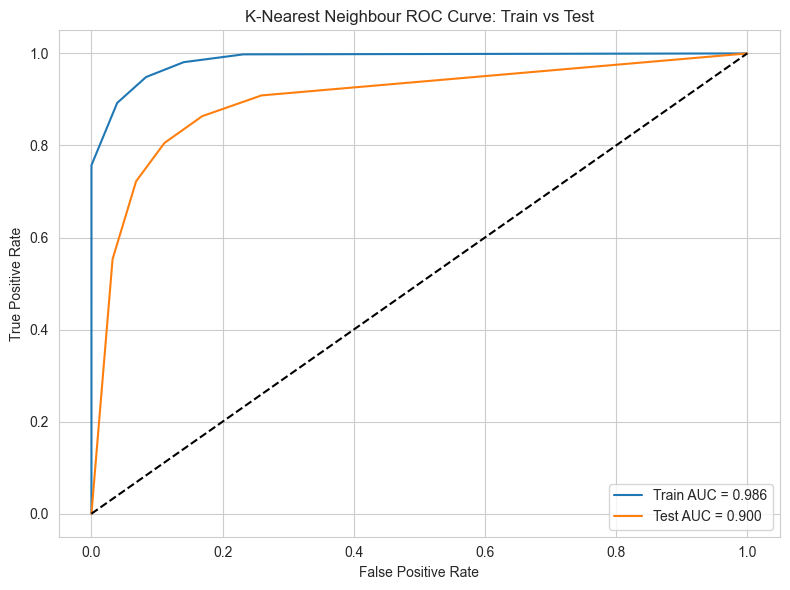

Metrics and Charting for k = 7



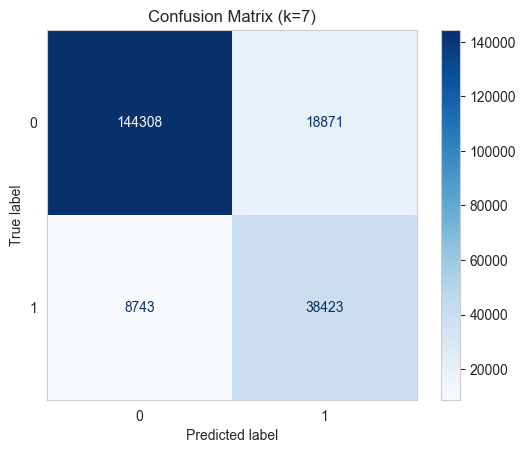

               Term  NoEmp  GrAppv  Default  Is_New  Is_Franchise  Is_LowDoc  \
LoanNr_ChkDgt                                                                  
1000014003       84      4   60000        0       1             0          1   
1000024006       60      2   40000        0       1             0          1   
1000034009      180      7  287000        0       0             0          0   
1000044001       60      2   35000        0       0             0          1   
1000084002      120     19  517000        0       0             0          0   
...             ...    ...     ...      ...     ...           ...        ...   
9995573004       60      6   70000        0       0             0          0   
9995603000       60      6   85000        0       0             0          0   
9995613003      108     26  300000        0       0             0          0   
9995973006       60      6   75000        1       0             0          1   
9996003010       48      1   30000      

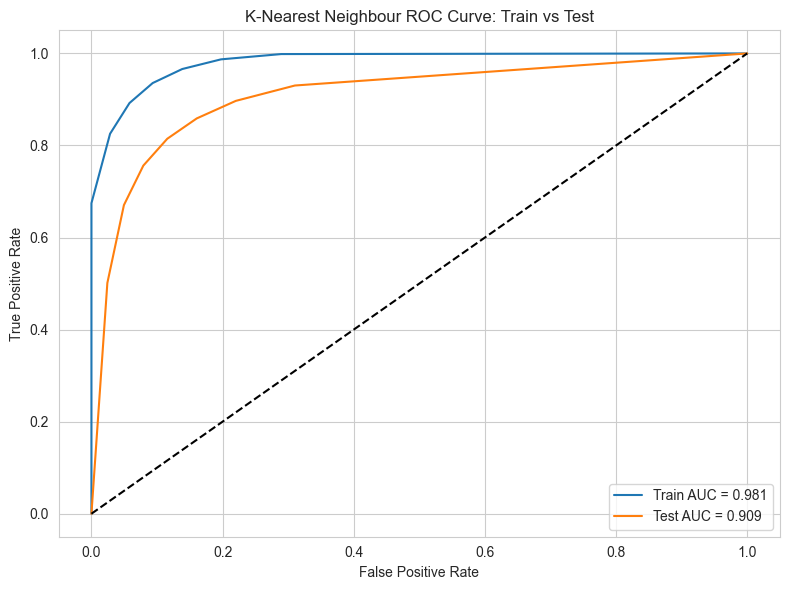

Metrics and Charting for k = 9



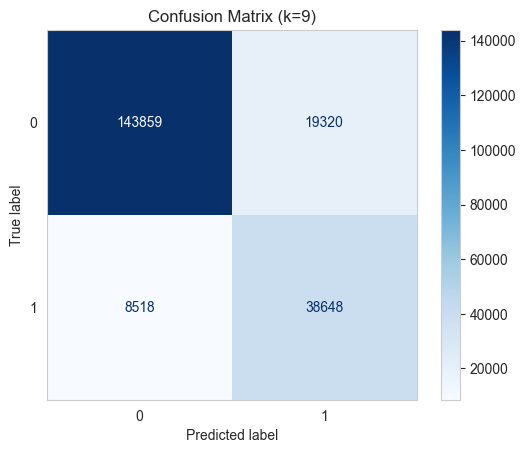

               Term  NoEmp  GrAppv  Default  Is_New  Is_Franchise  Is_LowDoc  \
LoanNr_ChkDgt                                                                  
1000014003       84      4   60000        0       1             0          1   
1000024006       60      2   40000        0       1             0          1   
1000034009      180      7  287000        0       0             0          0   
1000044001       60      2   35000        0       0             0          1   
1000084002      120     19  517000        0       0             0          0   
...             ...    ...     ...      ...     ...           ...        ...   
9995573004       60      6   70000        0       0             0          0   
9995603000       60      6   85000        0       0             0          0   
9995613003      108     26  300000        0       0             0          0   
9995973006       60      6   75000        1       0             0          1   
9996003010       48      1   30000      

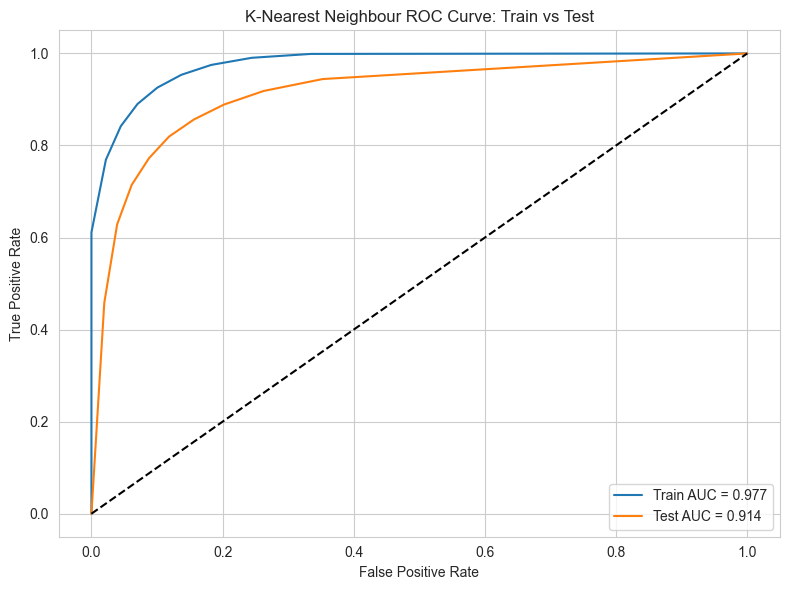

   Accuracy  Precision  Recall (TPR)  F1 Score       FNR       FPR       TNR  \
0  0.865654   0.690368      0.726858  0.708144  0.273142  0.094228  0.905772   
1  0.870893   0.684343      0.787432  0.732277  0.212568  0.104983  0.895017   
2  0.870014   0.676489      0.805517  0.735386  0.194483  0.111344  0.888656   
3  0.868720   0.670629      0.814633  0.735650  0.185367  0.115646  0.884354   
4  0.867656   0.666713      0.819404  0.735214  0.180596  0.118398  0.881602   

    G-Score  Error Rate  k  
0  0.811399    0.134346  1  
1  0.839503    0.129107  3  
2  0.846066    0.129986  5  
3  0.848778    0.131280  7  
4  0.849934    0.132344  9  


In [26]:
k_range = range(1, 10, 2)
master_df = pd.DataFrame() 

for k in k_range:
    print(f"Metrics and Charting for k = {k}\n")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    result_dict = ml.get_knn_metrics(knn, X_test_scaled, y_test, k = k)
    result_df = pd.DataFrame([result_dict])  # convert dict to 1-row DataFrame
    master_df = pd.concat([master_df, result_df], ignore_index = True)
    ml.plot_roc_train_vs_test(model_name,knn, X_train_scaled, y_train, X_test_scaled, y_test)
    
print(master_df)

In [29]:
master_df = master_df.rename(columns={
    'Recall (TPR)': 'TPR',
    'FPR': 'FPR',  # if already named correctly, you can keep or remove
    'Precision': 'Precision',
    'Error Rate': 'Error Rate',
    'G-Score': 'G Score',
    'F1 Score': 'F1 Score'
})

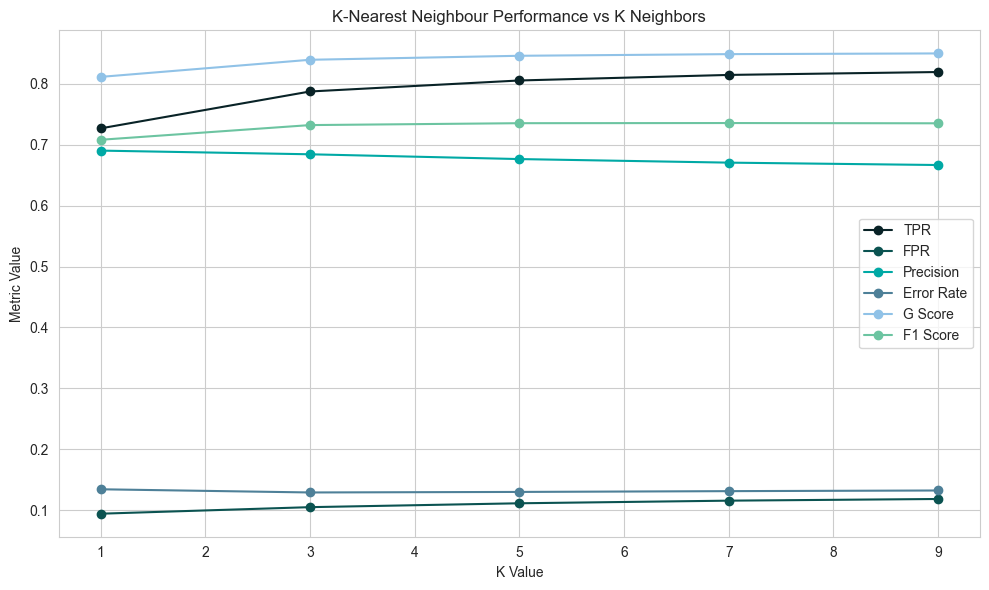

In [30]:
ml.plot_metrics_vs_thresholds(model_name, master_df, mode= "knn")

In [ ]:
ml.cross_validate_across_k(X_train_imb, y_train_imb, cv=5)

 Applied SMOTE: Resampled class distribution: {0: 304600, 1: 304600}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304600, 1: 304600}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304600, 1: 304600}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class di

,k,Accuracy,Precision,Recall (TPR),F1 Score,FNR,FPR,TNR,G-Score,Error Rate
0,1,0.863381,0.685075,0.723161,0.703602,0.276839,0.096089,0.903911,0.808500,0.136619
1,3,0.867267,0.675962,0.783804,0.725895,0.216196,0.108609,0.891391,0.835867,0.132733
2,5,0.865415,0.666021,0.802004,0.727705,0.197996,0.116257,0.883743,0.841880,0.134585
3,7,0.863970,0.660473,0.809528,0.727437,0.190472,0.120294,0.879706,0.843886,0.136030
4,9,0.862503,0.656057,0.813072,0.726172,0.186928,0.123209,0.876791,0.844329,0.137497


<h1> Bagging </h1>

In [32]:
model_name= "Bagging Classifier"
model_type = 'bag' 

In [33]:
bal_model = ml.train_model(model_type, X_train_scaled, y_train, tune=True, n_iter = 10)  # tune=True enables tuning with option to choose RandomSearch or GridSearch

Tuning combinations received, moving to model fitting ...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuning model search complete ...

 Best Model Parameters: {'n_estimators': 30, 'max_samples': 0.5, 'max_features': 0.75}


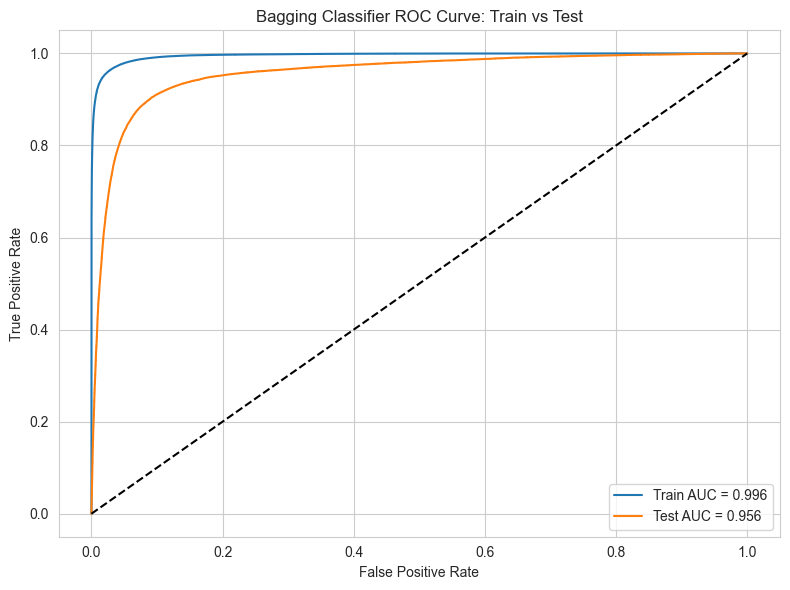

In [34]:
ml.plot_roc_train_vs_test(model_name,bal_model, X_train_scaled, y_train, X_test_scaled, y_test)


 Metrics across thresholds:
   Threshold     TPR     FPR  Precision  Error Rate  G Score  F1 Score     FNR
0       0.10  0.9762  0.4163     0.4040      0.3283   0.7549    0.5715  0.0238
1       0.20  0.9398  0.1530     0.6396      0.1322   0.8922    0.7612  0.0602
2       0.35  0.8867  0.0770     0.7689      0.0852   0.9047    0.8236  0.1133
3       0.50  0.8256  0.0484     0.8314      0.0767   0.8863    0.8285  0.1744


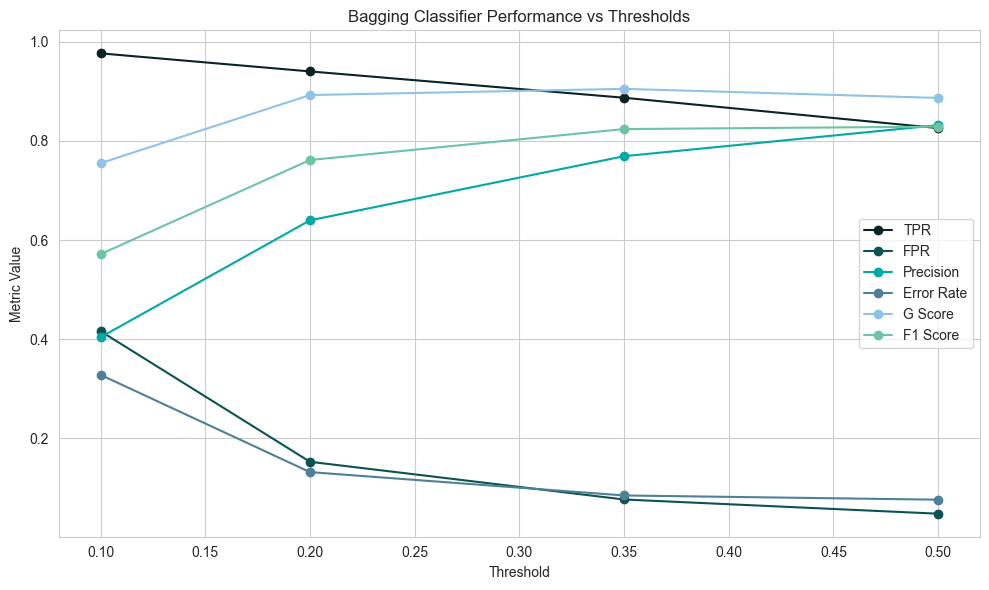

In [35]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.1, 0.2, 0.35, 0.5])
ml.plot_metrics_vs_thresholds(model_name,threshold_df)

In [36]:
ml.cross_validate_thresholds(bal_model, X_train_imb, y_train_imb)

 Applied SMOTE: Resampled class distribution: {0: 304600, 1: 304600}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}
 Applied SMOTE: Resampled class distribution: {0: 304601, 1: 304601}

Cross-Validated Metrics across Thresholds:
   Threshold  F1_mean  Recall_mean  Precision_mean  FNR_mean  FPR_mean  \
0       0.10   0.5715       0.9756          0.4041    0.0244    0.4158   
1       0.20   0.7607       0.9403          0.6387    0.0597    0.1537   
2       0.35   0.8239       0.8877          0.7687    0.1123    0.0772   
3       0.50   0.8289       0.8265          0.8313    0.1735    0.0485   

   Error_mean  
0      0.3280  
1      0.1326  
2      0.0851  
3      0.0765  


,Threshold,F1_mean,Recall_mean,Precision_mean,FNR_mean,FPR_mean,Error_mean
0,0.10,0.5715,0.9756,0.4041,0.0244,0.4158,0.3280
1,0.20,0.7607,0.9403,0.6387,0.0597,0.1537,0.1326
2,0.35,0.8239,0.8877,0.7687,0.1123,0.0772,0.0851
3,0.50,0.8289,0.8265,0.8313,0.1735,0.0485,0.0765


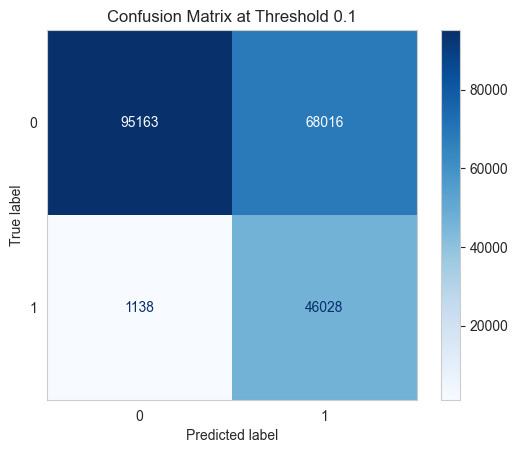

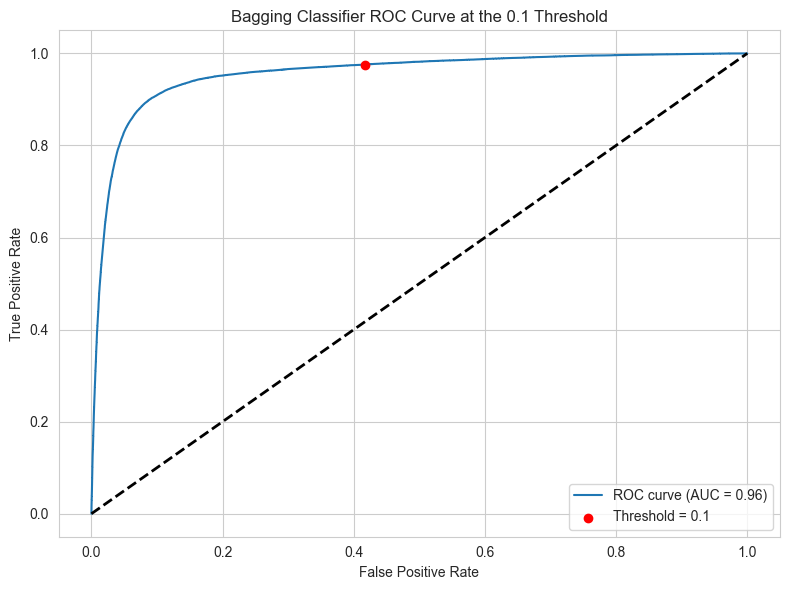

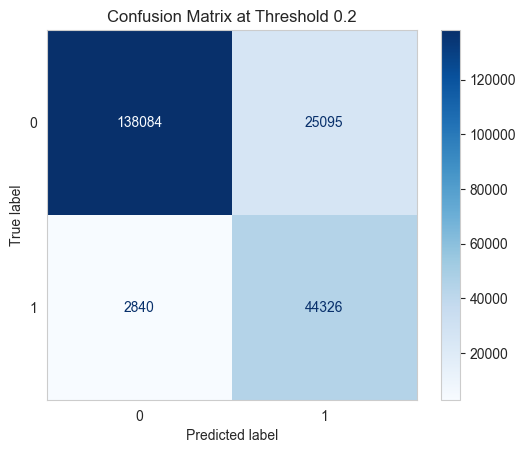

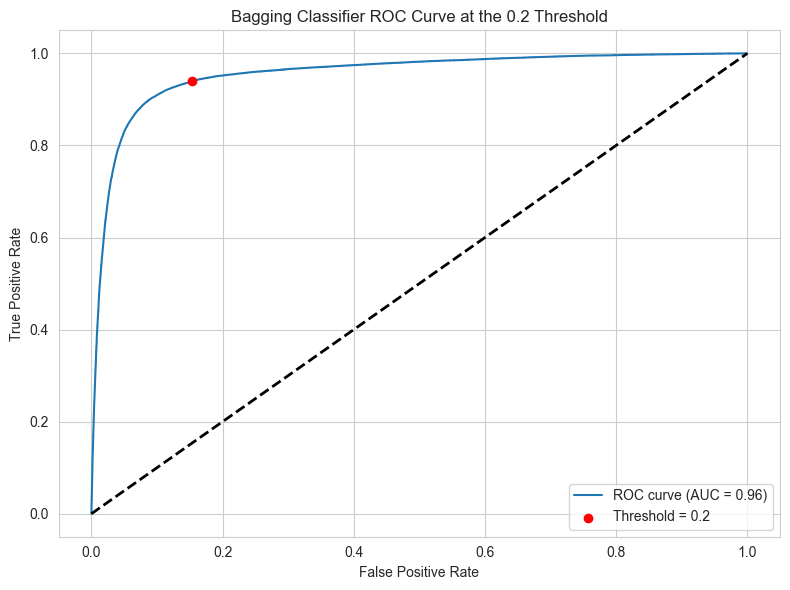

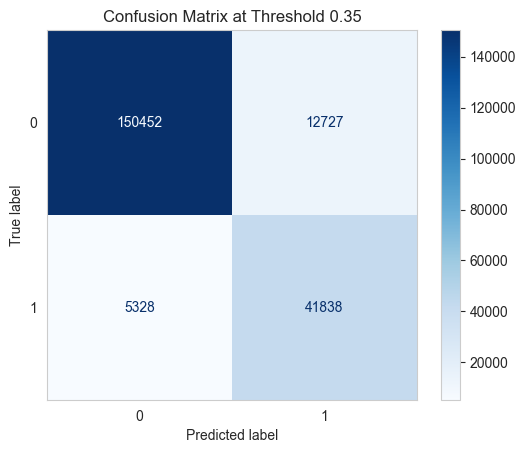

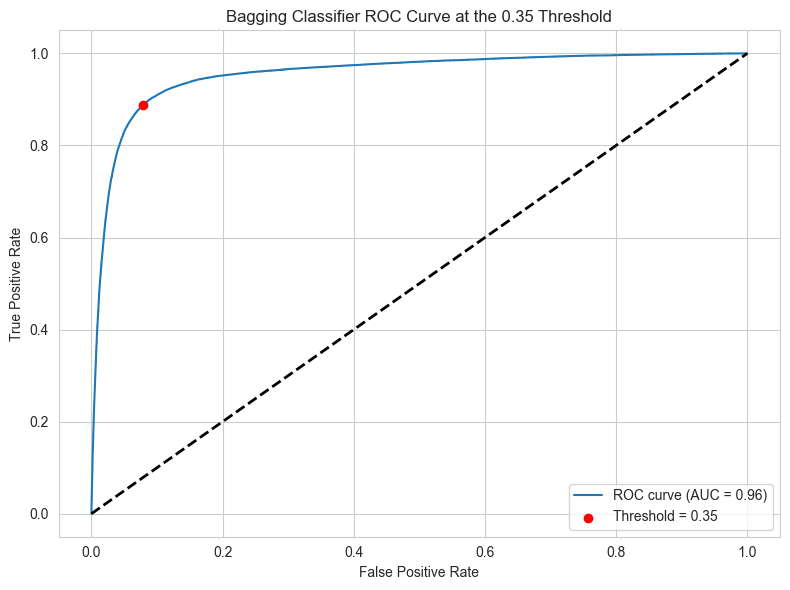

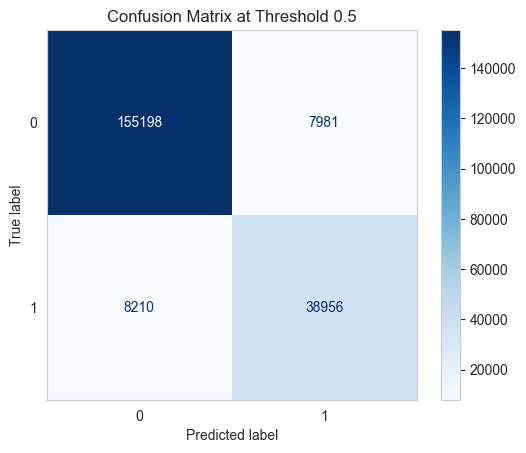

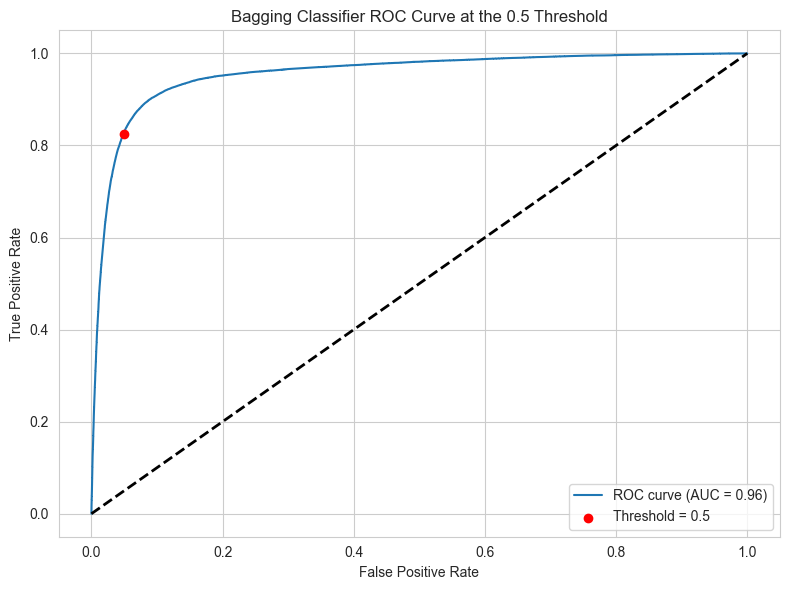

In [37]:
thresholds=[0.1, 0.2, 0.35, 0.5]
for threshold in thresholds:
    ml.plot_confusion_matrix_at_threshold(bal_model, X_test_scaled, y_test, threshold=threshold)
    ml.plot_roc_with_threshold(model_name,bal_model, X_test_scaled, y_test, threshold=threshold)

<h1> SVM </h1>

<h3> Due to the limitations on the computational power of our laptops and the heavy computational load of the SVM we were unable to run the code in any reasonable timeframe and so have not included it in our report </h3> 

In [ ]:
model_name = "SVM"
model_type = 'svm'

In [ ]:
model_type = 'svm'
bal_model = ml.train_model(model_type, X_train_scaled, y_train,scoring='f1')

Fitting model on full training set in 3, 2, 1 ...



In [ ]:
ml.plot_roc_train_vs_test(model_name,bal_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
threshold_df = ml.evaluate_thresholds(bal_model, X_test_scaled, y_test, thresholds=[0.5])
ml.plot_metrics_vs_thresholds(model_name,threshold_df)

In [ ]:
ml.cross_validate_thresholds(bal_model, X_train_scaled, y_train)